# Machine Learning Final Project

## Step 0: Project Ideation & Dataset Inspection

### Instructions
1. **Dataset Loading**:

    - For each plan (e.g., Plan A, Plan B, etc.), read in the corresponding dataset.

2. **Inspect the Dataset**:

    - After loading the dataset, display the first few rows to understand its structure.

    - Identify and list the types of fields (e.g., numerical, categorical, text).

    - Attempt to identify the target variable if your project involves supervised learning.

### Plan A: Animal drug use adverse event

In [2]:
# # Your code here
# import pandas as pd
# import re
# import requests

# # Define the base URL and initial query parameters
# url = 'https://api.fda.gov/animalandveterinary/event.json?'
# search = 'search=drug.active_ingredients.name:"Moxidectin"&limit=1000'
# url = url + search

# results = []

# while True:
#     # Make the request to the API
#     a = requests.get(url)
#     data = a.json()
    
#     # Convert the JSON response to a DataFrame and select specific columns
#     df = pd.DataFrame(data['results'])
#     df = df[['treated_for_ae', 'reaction', 'time_between_exposure_and_onset', 'drug', 'health_assessment_prior_to_exposure', 'onset_date', 'animal', 'type_of_information', 'serious_ae', 'outcome']]
#     results.append(df)
    
#     # Try to get the next page URL from the 'Link' header
#     try:
#         link_header = a.headers.get('Link', '')
#         b = re.search(r'<(https[^>]+)>', link_header)
#         if b:
#             next_url = b.group(1)
#             url = next_url
#         else:
#             break
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         break

# # Concatenate all DataFrames into one
# df_combined = pd.concat(results, axis=0)

# # Print information about the final DataFrame
# df_combined.info()

In [3]:
# # Inspect the first five rows
# df_combined.head()

In [4]:
# df_combined.shape

Because some of the fields are JSON objects, we want to further inspect them. 

We will want to parse these JSON objects in a way that is ingestible for our model. This will occur during EDA.

In [5]:
# row_index = 0
# column_label = 'outcome'
# df_combined.iloc[row_index][column_label]

### Plan B: Biomedical Image Analysis

In [6]:
!pip install medmnist

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
# Your code here
import medmnist
from medmnist import INFO
import numpy as np
from tqdm import tqdm
import pandas as pd

# Download the dataset
data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Load training and testing datasets
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)

# Inspect the dataset
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# Example of loading the dataset into a DataLoader
train_loader = [(np.array(img), label) for img, label in tqdm(train_dataset)]
test_loader = [(np.array(img), label) for img, label in tqdm(test_dataset)]

100%|██████████| 205615438/205615438 [00:08<00:00, 23593207.62it/s]


Using downloaded and verified file: /home/vscode/.medmnist/pathmnist.npz
Train dataset size: 89996
Test dataset size: 7180


100%|██████████| 7180/7180 [00:00<00:00, 32345.35it/s]


Convert `train_loader` and `test_loader` into Dataframes, `train_df` and `test_df`. We can store these dataframes in a SQL databases for safekeeping (Step 3).

In [2]:
# Convert train_loader to DataFrame
train_df = pd.DataFrame(train_loader, columns=['img', 'label'])

# Convert test_loader to DataFrame
test_df = pd.DataFrame(test_loader, columns=['img', 'label'])

# Inspect train_df
train_df.head()

,img,label
0,"[[[220, 208, 227], [219, 207, 227], [220, 207,...",[0]
1,"[[[126, 59, 119], [142, 84, 139], [174, 127, 1...",[4]
2,"[[[223, 168, 204], [223, 166, 203], [218, 170,...",[7]
3,"[[[216, 135, 183], [216, 127, 178], [213, 125,...",[5]
4,"[[[204, 124, 177], [204, 116, 170], [211, 149,...",[5]


Each row represents an image and its corresponding label. The values you see under `img` are the pixel values of the images. These arrays are typically multi-dimensional, with each dimension corresponding to different properties of the image. Let's inspect a single image,

In [9]:
# Select an index to view
index = 4  # Change this to view a different image

# From the train_dataset
image, label = train_dataset[index]

# Or from the train_loader
# image, label = train_loader[index]

# Convert image to numpy array if needed
image = np.array(image)
image

array([[[204, 124, 177],
        [204, 116, 170],
        [211, 149, 190],
        ...,
        [216, 153, 194],
        [224, 185, 214],
        [233, 211, 228]],

       [[207, 132, 182],
        [209, 141, 188],
        [205, 127, 176],
        ...,
        [216, 153, 194],
        [227, 190, 217],
        [235, 217, 232]],

       [[226, 179, 211],
        [215, 156, 197],
        [212, 150, 193],
        ...,
        [207, 141, 185],
        [211, 154, 193],
        [229, 196, 219]],

       ...,

       [[216, 171, 205],
        [206, 151, 191],
        [214, 162, 200],
        ...,
        [217, 173, 207],
        [219, 176, 207],
        [225, 197, 220]],

       [[210, 164, 200],
        [218, 168, 203],
        [228, 199, 221],
        ...,
        [215, 164, 202],
        [219, 181, 210],
        [227, 209, 227]],

       [[231, 214, 229],
        [228, 202, 223],
        [231, 204, 224],
        ...,
        [194, 124, 176],
        [217, 170, 205],
        [229, 206, 225]]

The images are in color because the array is 3D with dimensions `(height, width, channels)`, where `channels` is usually 3 (representing the Red, Green, and Blue color channels). Each element in the array represents the intensity of the corresponding color channel for a pixel.

Below we can see that the images are 28x28 pixels and RGB (in color),

In [10]:
np.shape(image)

(28, 28, 3)

These arrays are used as input for machine learning models, where the model processes these pixel values to learn patterns and make predictions based on the images.

Lets use `matplotlib` to render the image from the pixel data,

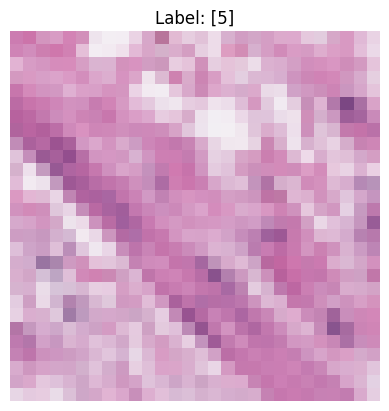

In [11]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(image, cmap='gray') 
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

Inspect 9 random images with their associated label,

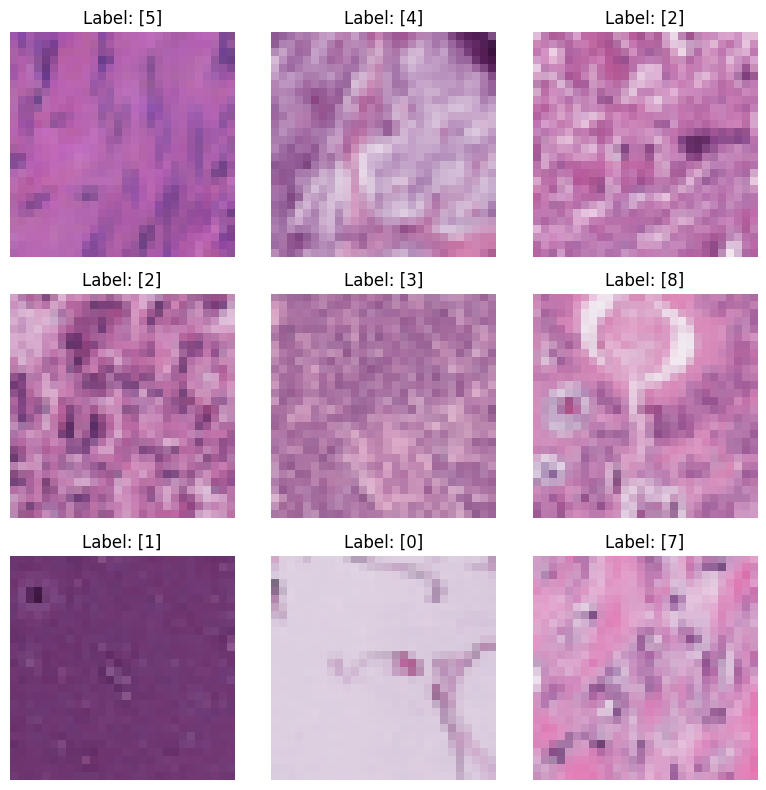

In [12]:
import random

# Select 9 random indices
random_indices = random.sample(range(len(train_dataset)), 9)

# Create a 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop over the 9 random indices and display each image
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[random_indices[i]]
    

    
    # Display the image
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
# Extract all labels from the train_dataset
labels = [label.item() for _, label in train_dataset]

# Get unique labels
unique_labels = list(set(labels))

# Print unique labels
print("Unique labels:", unique_labels)

Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8]


Mapping of the labels:

In [14]:
print(info['label'])

{'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


### Plan C: Website Fact Checker

In [15]:
# Your code here

## Step 1: Problem definition

### Instructions

1. **Select a Project Plan:**

    - Review the dataset options from Plan A, Plan B, and Plan C.

    - Choose one of the plans to move forward with based on your dataset inspection and interest.

2. **Write a Project Description:**

    - Clearly define the problem or question you intend to address with your selected dataset.

    - Consider how your chosen dataset can help solve this problem or answer the question.

    - Write a one-sentence description that clearly states the objective of your project. This should include what you aim to achieve or understand with the dataset.

3. **Name the Project:**

    - Create a name for your project that reflects the focus of your work.

### 1. Select a Project Plan

Plan B: Predicting Colon Cancer Histology Slide Content Using Deep Learning

### 2. Write a Project Description

Problem Definition:
The project aims to develop a machine learning model capable of accurately predicting the content of histology slides related to colon cancer. This involves analyzing images of colon cancer tissue to identify specific features and patterns that can indicate the presence and type of cancerous cells. The dataset comprises 100,000 non-overlapping image patches, each representing one of nine classes: adipose tissue (ADI), background (BACK), debris (DEB), lymphocyte (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), and CRC Epithelium (TUM). Accurately classifying these image patches is crucial for aiding in the diagnosis and treatment planning of colon cancer.

Dataset Utilization:
The chosen dataset from MedMNIST.com provides a collection of labeled histology images specific to colon cancer. By training the model on this dataset, we aim to create a tool that can assist pathologists in diagnosing colon cancer more effectively.

Objective:
The objective of this project is to use deep learning techniques to classify and predict the contents of colon cancer histology slides, ultimately aiding in the early and accurate detection of colon cancer.

### 3. Name the Project

Project Title: Predicting Colon Cancer Histology Slide Content Using Deep Learning

## Step 2: Acquiring and loading the data set

### Instructions

1. **Acquiring the Dataset:** Describe how you have acquired the dataset for your project. Depending on the method you used:

    1. **Web Scraping:**

        - If you used web scraping, provide details about the website or web page from which you extracted data.

        - Include information on the tools or libraries you used for scraping (e.g., BeautifulSoup, Scrapy).

        - Mention any challenges faced during the scraping process and how you addressed them.

    2. **SQL Database:**

        - If you obtained data from a public database using SQL, specify the database you accessed.

        - Describe the SQL queries you used to extract the data.

        - Include any relevant details about the database schema and how you navigated it.

    3. **Public API:**

        - If you accessed data through a public API, provide details about the API.

        - Describe the API endpoints you used and any parameters or filters applied to your requests.

        - Mention the format of the data returned by the API and how you processed it.

2. **Loading the Dataset:**

    - Detail the steps you followed to load the dataset into your working environment.

    - Describe the tools or libraries used for loading the data (e.g., `Pandas` for CSV files, `SQLAlchemy` for SQL databases, `requests` or an API client library for APIs).

    - Include any data cleaning or preprocessing steps you performed to prepare the data for analysis.

3. **Document Your Process:**

    - Provide a brief summary of your data acquisition and loading process, highlighting any key steps or decisions.

    - Include any challenges or issues encountered and how you resolved them.

There is a premade package that we have downloaded and used the documentation to dowload all of the images and set them up in an SQL database.  Though, honestly, using the prebuilt custom DataLoader class based in pytorch will likely be much more sensible for our purposes, as it will automatically batch the images and take care of much of the headache.

## Step 3: Store the information

### Instructions

1. **Choose a Database:**

    - Select a database that is most compatible with your dataset. Consider factors such as the size of the data, the complexity of the queries you plan to perform, and the features offered by the database.

    - The databases we have studied include SQLite, PostgreSQL, MySQL, etc.

2. **Store the Data:**

    - Import the dataset into the chosen database. This may involve creating tables and defining schemas that match the structure of your data.

    - Ensure that the database is properly set up to handle the data efficiently. Consider indexing or other optimizations if necessary.

3. **Perform Queries:**

    - Write and execute SQL queries to interact with your stored data. Use the following types of queries:

        - `SELECT`: Retrieve specific data from your tables. For example, you can select columns or rows that meet certain criteria.

        - `JOIN`: Combine data from multiple tables based on related columns to perform more complex queries.

        - `INSERT`: Add new data to your tables if necessary.

        - Include any other relevant SQL operations that are useful for your analysis.
    
    - Alternatively, use Python wrappers for SQL (e.g., `SQLAlchemy`, `pandas`) if applicable. These wrappers can help you perform SQL operations more easily within a Python environment.

4. **Document Your Process:**

    - Provide a summary of how you stored your data in the database, including the database used and the structure of the tables.

    - Include examples of the SQL queries you wrote and explain how they help in starting the analysis.

    - Discuss any challenges faced during the data storage and querying process and how you addressed them.

In [16]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('../Bump/DBIITheReckoning.db')

train_df.to_sql('Train_Data', conn, if_exists='replace', index=False)
test_df.to_sql('Test_Data', conn, if_exists='replace', index=False)

7180

1. Write a SQL `SELECT` statement to retrieve all the data from your training set table &

2. Write a SQL `SELECT` statement to retrieve all the data from your test set table:

In [17]:
# Initialize an empty list to store dataframes
dfs = []

cursor = conn.cursor()
query = 'SELECT * FROM '
for i in ['Train_Data', 'Test_Data']:
    que = query + i
    cursor.execute(que)

    # Fetch all the records and convert them to a dataframe
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

    # Convert the byte data back into numpy arrays
    df['img'] = df['img'].apply(lambda x: np.frombuffer(x, dtype=np.uint8).reshape(28, 28, 3))  # Adjust the shape as per your data
    df['label'] = df['label'].apply(lambda x: np.frombuffer(x, dtype=np.int64))  # Adjust dtype as per your data

    # Append the dataframe to the list
    dfs.append(df)

Inspect the retrieved data and ensure they match the inputs `train_df` and `test_df`,

In [18]:
retrieved_train_data = dfs[0]
retrieved_train_data

,img,label
0,"[[[220, 208, 227], [219, 207, 227], [220, 207,...",[0]
1,"[[[126, 59, 119], [142, 84, 139], [174, 127, 1...",[4]
2,"[[[223, 168, 204], [223, 166, 203], [218, 170,...",[7]
3,"[[[216, 135, 183], [216, 127, 178], [213, 125,...",[5]
4,"[[[204, 124, 177], [204, 116, 170], [211, 149,...",[5]
...,...,...
89991,"[[[220, 206, 226], [219, 205, 225], [219, 205,...",[0]
89992,"[[[194, 154, 194], [198, 159, 198], [193, 151,...",[6]
89993,"[[[201, 141, 191], [202, 142, 193], [191, 124,...",[2]
89994,"[[[226, 215, 229], [225, 213, 228], [192, 155,...",[0]


In [19]:
retrieved_test_data = dfs[1]
retrieved_test_data

,img,label
0,"[[[190, 114, 165], [172, 98, 153], [152, 83, 1...",[8]
1,"[[[200, 159, 199], [178, 108, 165], [177, 98, ...",[4]
2,"[[[238, 230, 238], [232, 218, 232], [230, 214,...",[4]
3,"[[[196, 154, 190], [196, 149, 188], [211, 164,...",[8]
4,"[[[233, 214, 230], [220, 191, 215], [207, 163,...",[4]
...,...,...
7175,"[[[190, 99, 150], [154, 81, 135], [151, 84, 14...",[8]
7176,"[[[188, 122, 170], [179, 117, 165], [191, 121,...",[7]
7177,"[[[173, 131, 180], [200, 166, 203], [178, 137,...",[4]
7178,"[[[132, 64, 123], [123, 61, 118], [140, 72, 13...",[8]


## Step 4 & 5: Perform a descriptive analysis & full EDA

1. **Getting the Dimensions of the Dataframe**

    - Get the dimensions of the `train_df`. This will give you the number of rows (images) and columns in the dataframe.

In [20]:
train_df.shape

(89996, 2)

$~~~~~~~~~~$- Get the dimensions of `test_df`.

In [21]:
test_df.shape

(7180, 2)

2. **Checking for Missing Values**

    - <span style="color: red;">**TODO: Check and count how many rows have missing values in `train_df`. Drop/remove rows with missing values if any.**</span>

In [22]:
# Your code here
# Check for missing values in each column
missing_values = test_df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Count the total number of rows with any missing values
rows_with_missing_values = test_df.isnull().any(axis=1).sum()
print(f'Total number of rows with missing values: {rows_with_missing_values}')

Missing values per column:
 img      0
label    0
dtype: int64
Total number of rows with missing values: 0


$~~~~~~~~~~$- <span style="color: red;">**TODO: Check and count how many rows have missing values in `test_df`. Drop/remove rows with missing values if any.**</span>

In [23]:
# Your code here
# Check for missing values in each column
missing_values = test_df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Count the total number of rows with any missing values
rows_with_missing_values = test_df.isnull().any(axis=1).sum()
print(f'Total number of rows with missing values: {rows_with_missing_values}')

Missing values per column:
 img      0
label    0
dtype: int64
Total number of rows with missing values: 0


3. **Checking the Data Types of Columns**

    - Check the data type of of each column in the `train_df` DataFrame.

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89996 entries, 0 to 89995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     89996 non-null  object
 1   label   89996 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


$~~~~~~~~~~$- Check the data type of of each column in the `test_df` DataFrame.

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7180 entries, 0 to 7179
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     7180 non-null   object
 1   label   7180 non-null   object
dtypes: object(2)
memory usage: 112.3+ KB


4. **Inspect the Data Type of `img`**

    - Inspect the data type of an individual `img` from `train_df`.

In [26]:

first_train_img = train_df['img'].iloc[0]
type(first_train_img)

print(f"Shape of the first image: {first_train_img.shape}")
print(f"Data type of the first image: {type(first_train_img)}")

Shape of the first image: (28, 28, 3)
Data type of the first image: <class 'numpy.ndarray'>


$~~~~~~~~~~$- Inspect the data type of an individual `img` from `test_df`.

In [27]:
first_test_img = test_df['img'].iloc[0]
type(first_test_img)

print(f"Shape of the first test image: {first_test_img.shape}")
print(f"Data type of the first test image: {type(first_test_img)}")

Shape of the first test image: (28, 28, 3)
Data type of the first test image: <class 'numpy.ndarray'>


5. **Inspect the Data Type of `label`**

    - Inspect the data type of an individual `label` from `train_df`.

    - Inspect the data type of an individual `label` from `test_df`.

In [28]:
for i in [train_df, test_df]:
    print(type(i['label'].iloc[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


6. **Casting the Label to an Integer**

    - Convert the `label` column from an array to an integer for `train_df`.

    - Convert the `label` column from an array to an integer for `test_df`.

<span style="color: red;">**TODO: Great attempt! But the following DOES NOT cast the `label` column to type integer. I added a validation check in the two code cells that follow your solution. As you can see the `label` column is still type array. Give it another attemp and run the validation checks to validate your solution.**</span>

In [29]:
# Convert the label column from an array to an integer in train_df
train_df['label'] = train_df['label'].apply(lambda x: int(x[0]))

# Convert the label column from an array to an integer in test_df
test_df['label'] = test_df['label'].apply(lambda x: int(x[0]))


In [30]:
for i in [train_df, test_df]:
    print(type(i['label'].iloc[0]))

<class 'numpy.int64'>
<class 'numpy.int64'>


Verifying that the data type of the `label` column is now an integer,

In [31]:
# Get the first train image label
first_train_img_label = train_df['label'].iloc[0]

print(f"First train img label: {first_train_img_label}")
print(f"Data type of first train img label: {type(first_train_img_label)}")

First train img label: 0
Data type of first train img label: <class 'numpy.int64'>


In [32]:
# Get the first test image label
first_test_img_label = test_df['label'].iloc[0]

print(f"First test img label: {first_test_img_label}")
print(f"Data type of first train img label: {type(first_test_img_label)}")

First test img label: 8
Data type of first train img label: <class 'numpy.int64'>


7. **Getting the Label Distribution**

    - Count the number of instances for each `label` in `train_df`.

In [33]:
train_df['label'].value_counts()

label
8    12885
5    12182
3    10401
2    10360
1     9509
7     9401
0     9366
4     8006
6     7886
Name: count, dtype: int64

$~~~~~~~~~~$- Count the number of instances for each `label` in `test_df`.

In [34]:
test_df['label'].value_counts()

label
0    1338
8    1233
4    1035
1     847
6     741
3     634
5     592
7     421
2     339
Name: count, dtype: int64

8. **Visualizing the Label Distribution**

    - Visualize the `label` distribution for `train_df` using a bar plot or histogram.

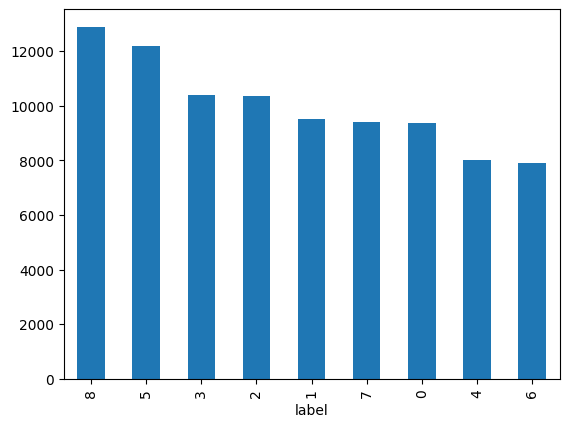

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

bar = train_df['label'].value_counts().plot(kind='bar')
plt.show()

$~~~~~~~~~~$- Visualize the `label` distribution for `test_df` using a bar plot or histogram.

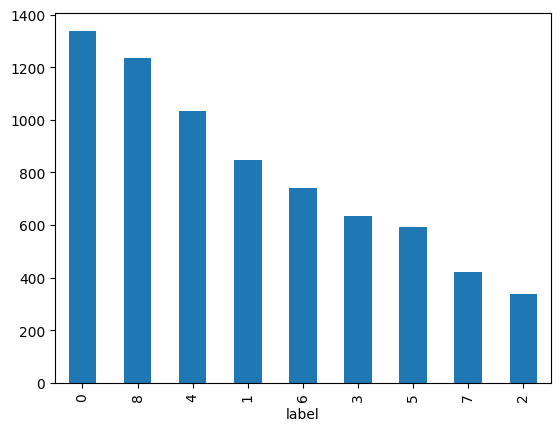

In [36]:
bar_nun = test_df['label'].value_counts().plot(kind='bar')
plt.show()

9. **Getting Image Dimensions**

    - Check the dimensions of the images to ensure consistency across the `train_df` dataset.

In [37]:
# Extract the dimensions of each image in the train_df
image_dimensions = train_df['img'].apply(lambda x: x.shape)

# Display unique dimensions to check for consistency
unique_dimensions = image_dimensions.unique()
print(f"Unique image dimensions: {unique_dimensions}")


Unique image dimensions: [(28, 28, 3)]


$~~~~~~~~~~$- Check the dimensions of the images to ensure consistency across the `test_df` dataset.

In [38]:
# Extract the dimensions of each image in the train_df
image_dimensions = test_df['img'].apply(lambda x: x.shape)

# Display unique dimensions to check for consistency
unique_dimensions = image_dimensions.unique()
print(f"Unique image dimensions: {unique_dimensions}")


Unique image dimensions: [(28, 28, 3)]


10. **Getting Pixel Intensity Statistics**

    - Calculate basic statistics (mean, standard deviation, min, max) of pixel intensities across all images in `train_df`.

In [39]:
import numpy as np


# Function to calculate statistics for a single image
def calculate_statistics(img):
    pixels = img.flatten()  # Flatten the image to a 1D array of pixel values
    mean = np.mean(pixels)
    std = np.std(pixels)
    min_val = np.min(pixels)
    max_val = np.max(pixels)
    return mean, std, min_val, max_val

# Apply the function to all images in the train_df and store the results
train_df['mean'], train_df['std'], train_df['min'], train_df['max'] = zip(*train_df['img'].apply(calculate_statistics))

# Display the first few rows to see the calculated statistics
print(train_df[['mean', 'std', 'min', 'max']].head(20))

funcs = {'avg':np.mean, 'std':np.std, 'min':np.min, 'max':np.max}
for k, v in funcs.items():
    train_df[k] = train_df['img'].apply(v)

          mean        std  min  max
0   216.181973  10.620905  164  228
1   172.227041  30.914786   47  235
2   189.426871  25.896489   80  237
3   175.971939  34.330515   86  234
4   187.073129  33.331816   71  243
5   152.146684  32.743361   61  240
6   159.522109  33.482194   66  240
7   152.753401  35.483139   57  236
8   176.772109  42.655796   65  242
9   161.115221  37.037957   64  214
10  156.053146  32.565700   60  235
11  169.707483  35.765753   71  232
12  143.960459  45.893665   48  248
13  140.946003  37.899898   43  235
14  231.277636   7.353435  210  240
15   97.197279  25.188899   51  130
16  150.765731  46.342943   54  233
17  175.422619  35.458236   33  242
18  147.679847  34.167392   65  238
19  153.312925  35.591095   59  221


Inspect `train_df` with the newly created columns (the aggregations),

In [40]:
train_df

,img,label,mean,std,min,max,avg
0,"[[[220, 208, 227], [219, 207, 227], [220, 207,...",0,216.181973,10.620905,164,228,216.181973
1,"[[[126, 59, 119], [142, 84, 139], [174, 127, 1...",4,172.227041,30.914786,47,235,172.227041
2,"[[[223, 168, 204], [223, 166, 203], [218, 170,...",7,189.426871,25.896489,80,237,189.426871
3,"[[[216, 135, 183], [216, 127, 178], [213, 125,...",5,175.971939,34.330515,86,234,175.971939
4,"[[[204, 124, 177], [204, 116, 170], [211, 149,...",5,187.073129,33.331816,71,243,187.073129
...,...,...,...,...,...,...,...
89991,"[[[220, 206, 226], [219, 205, 225], [219, 205,...",0,203.438776,25.845920,33,228,203.438776
89992,"[[[194, 154, 194], [198, 159, 198], [193, 151,...",6,188.321854,29.076016,75,243,188.321854
89993,"[[[201, 141, 191], [202, 142, 193], [191, 124,...",2,168.399660,30.417645,91,218,168.399660
89994,"[[[226, 215, 229], [225, 213, 228], [192, 155,...",0,214.323554,23.111225,44,230,214.323554


$~~~~~~~~~~$- Calculate basic statistics (mean, standard deviation, min, max) of pixel intensities across all images in `test_df`.

In [41]:
for k, v in funcs.items():
    test_df[k] = test_df['img'].apply(v)

test_df

,img,label,avg,std,min,max
0,"[[[190, 114, 165], [172, 98, 153], [152, 83, 1...",8,137.809099,43.328064,31,244
1,"[[[200, 159, 199], [178, 108, 165], [177, 98, ...",4,172.886054,31.001875,58,232
2,"[[[238, 230, 238], [232, 218, 232], [230, 214,...",4,191.959184,28.550678,65,238
3,"[[[196, 154, 190], [196, 149, 188], [211, 164,...",8,164.517007,39.508154,53,246
4,"[[[233, 214, 230], [220, 191, 215], [207, 163,...",4,195.914116,43.954380,27,242
...,...,...,...,...,...,...
7175,"[[[190, 99, 150], [154, 81, 135], [151, 84, 14...",8,132.568452,38.661683,40,236
7176,"[[[188, 122, 170], [179, 117, 165], [191, 121,...",7,180.988946,32.943531,58,245
7177,"[[[173, 131, 180], [200, 166, 203], [178, 137,...",4,174.014031,25.252185,83,224
7178,"[[[132, 64, 123], [123, 61, 118], [140, 72, 13...",8,148.875000,51.205714,35,244


11. **Analyzing a Correlation Between Image Intensity and Labels**

    - Analyze if there is any relationship between the average pixel intensity of an image and its label for `train_df`.

In [49]:
# Calculate the average pixel intensity for each image
train_df['avg'] = train_df['img'].apply(lambda x: np.mean(x))
train_df


,img,label,mean,std,min,max,avg
0,"[[[220, 208, 227], [219, 207, 227], [220, 207,...",0,216.181973,10.620905,164,228,216.181973
1,"[[[126, 59, 119], [142, 84, 139], [174, 127, 1...",4,172.227041,30.914786,47,235,172.227041
2,"[[[223, 168, 204], [223, 166, 203], [218, 170,...",7,189.426871,25.896489,80,237,189.426871
3,"[[[216, 135, 183], [216, 127, 178], [213, 125,...",5,175.971939,34.330515,86,234,175.971939
4,"[[[204, 124, 177], [204, 116, 170], [211, 149,...",5,187.073129,33.331816,71,243,187.073129
...,...,...,...,...,...,...,...
89991,"[[[220, 206, 226], [219, 205, 225], [219, 205,...",0,203.438776,25.845920,33,228,203.438776
89992,"[[[194, 154, 194], [198, 159, 198], [193, 151,...",6,188.321854,29.076016,75,243,188.321854
89993,"[[[201, 141, 191], [202, 142, 193], [191, 124,...",2,168.399660,30.417645,91,218,168.399660
89994,"[[[226, 215, 229], [225, 213, 228], [192, 155,...",0,214.323554,23.111225,44,230,214.323554


In [50]:
# Group by label and calculate the mean average intensity for each label
mean_intensity_by_label = train_df.groupby('label')['avg'].mean().reset_index()


In [51]:
# Pivot the table for heatmap
heatmap_data = mean_intensity_by_label.pivot_table(index='label', columns='label', values='avg')

# Check for NaN values in the DataFrame
nan_check = heatmap_data.isna()
print(nan_check)





label      0      1      2      3      4      5      6      7      8
label                                                               
0      False   True   True   True   True   True   True   True   True
1       True  False   True   True   True   True   True   True   True
2       True   True  False   True   True   True   True   True   True
3       True   True   True  False   True   True   True   True   True
4       True   True   True   True  False   True   True   True   True
5       True   True   True   True   True  False   True   True   True
6       True   True   True   True   True   True  False   True   True
7       True   True   True   True   True   True   True  False   True
8       True   True   True   True   True   True   True   True  False


In [52]:
# Count NaN values per column
nan_counts_per_column = heatmap_data.isna().sum()
print("NaN counts per column:\n", nan_counts_per_column)

# Count NaN values per row
nan_counts_per_row = heatmap_data.isna().sum(axis=1)
print("NaN counts per row:\n", nan_counts_per_row)


NaN counts per column:
 label
0    8
1    8
2    8
3    8
4    8
5    8
6    8
7    8
8    8
dtype: int64
NaN counts per row:
 label
0    8
1    8
2    8
3    8
4    8
5    8
6    8
7    8
8    8
dtype: int64


In [53]:
# Calculate mean values for each column, ignoring NaNs
mean_values = heatmap_data.mean()


# Fill NaN values with a specific value
heatmap_data_filled = heatmap_data.fillna(mean_values)


mean_values

label
0    207.608257
1    142.267858
2    165.076369
3    156.926722
4    180.911779
5    172.785425
6    165.692781
7    171.184727
8    157.742965
dtype: float64

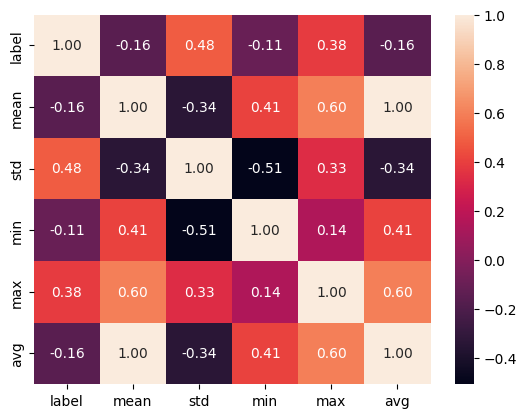

In [54]:
corr = train_df.drop(columns='img').corr()
sns.heatmap(corr, annot=True, fmt='.2f', cbar=True)
plt.show()

$~~~~~~~~~~$- Analyze if there is any relationship between the average pixel intensity of an image and its label for `test_df`.

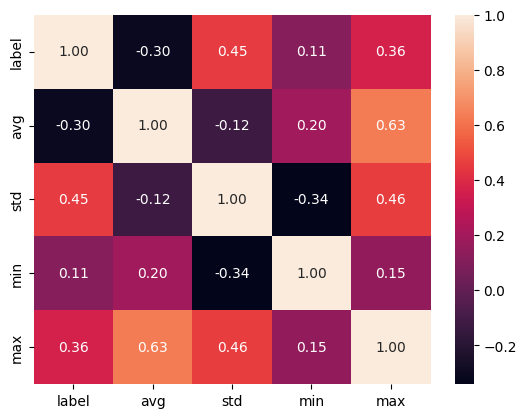

In [55]:
corr = test_df.drop(columns='img').corr()
sns.heatmap(corr, annot=True, fmt='.2f', cbar=True)
plt.show()

/tmp/ipykernel_31110/1280564718.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_intensity_mean.index, y=label_intensity_mean.values, palette='viridis')


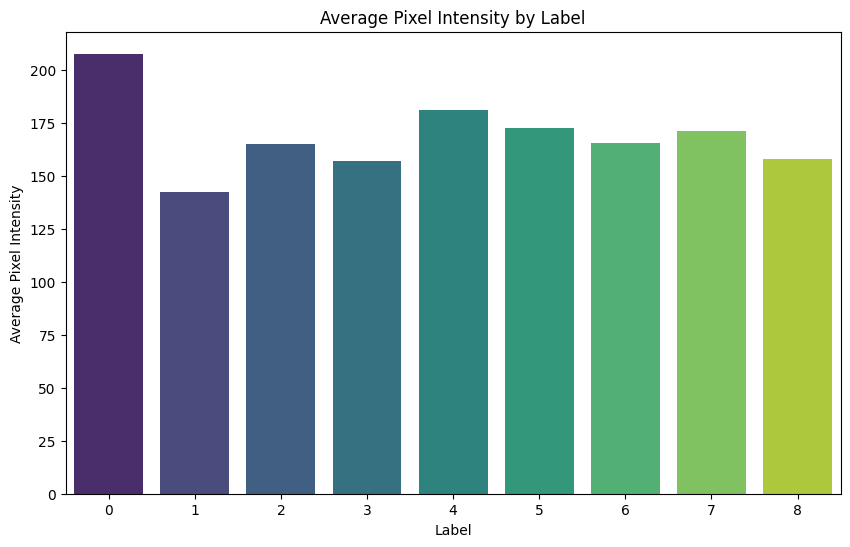

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
# Group by label and calculate the mean of average pixel intensity
label_intensity_mean = train_df.groupby('label')['mean'].mean()

# Plot the relationship between label and average pixel intensity
plt.figure(figsize=(10, 6))
sns.barplot(x=label_intensity_mean.index, y=label_intensity_mean.values, palette='viridis')
plt.title('Average Pixel Intensity by Label')
plt.xlabel('Label')
plt.ylabel('Average Pixel Intensity')
plt.show()

## Step 6: Build the model and optimize it
<span style="color: red;">**TODO: Use `train_df` and `test_df` to train and evaluate your model. <u>DO NOT</u> use `train_loader` and `test_loader` since `DataLoader`/`DataClass` objects were not covered in this course.**</span>

### 6.1 Prepare the Data

- **Extract Features and Labels:** You'll need to separate your features (images) and labels in both dataframes.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.cluster import KMeans
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from keras.utils import to_categorical
import tensorflow as tf
import warnings

In [12]:
def batch(batch_size, drop_last=True, test=False, skip=None):
    if skip is None:
        df = train_df if not test else test_df
    else:
        df = skip
        print(1)
    def generator():
        for img, label, group in zip(df['img'].values, df['label'].values, df['group'].values):
            img = tf.convert_to_tensor(img.astype(np.float32))
            label = tf.convert_to_tensor(label, dtype=tf.float32)
            label = to_categorical(label, num_classes=9)
            group = tf.convert_to_tensor(group, dtype=tf.int64)
            yield img, label, group

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(9,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

#The batching process of the DataSet yields a generator in place of a Data loader that sends
#targets and features to the right place down the line automatically, hence why I'm doing it
#this way.


- **Preprocess the Images:** Ensure your images are in the correct format and shape. Most machine learning libraries require images to be in a numerical array format (e.g., NumPy arrays) and of consistent size.

In [8]:
with open('../models/kmodel.dat', 'rb') as file:
    kmodel = pickle.load(file)

def preprocess(img):
    red, green, blue = img[:, :, 0].flatten().tolist(), img[:, :, 1].flatten().tolist(), img[:, :,
                                                                                            2].flatten().tolist()
    colors = {'red': red, 'green': green, 'blue': blue}
    funcs = {'_avg': np.mean, '_std': np.std, '_max': np.max, '_min': np.min}
    results = {}
    for _name, func in funcs.items():
        for name, color in colors.items():
            results[name + _name] = func(color)
    model_num = kmodel.predict(pd.DataFrame(results, index=[0]))[0]
    img = img / 255.0
    img = img.astype('float32')
    return img, model_num

def prepare():
    img = train_df['img'].apply(preprocess)
    train_df['img'] = [i[0] for i in img]
    train_df['group'] = [i[1] for i in img]
    img = test_df['img'].apply(preprocess)
    test_df['img'] = [i[0] for i in img]
    test_df['group'] = [i[1] for i in img]
    train_df['label'] = [i[0] for i in train_df['label']]
    train_df['label'] = to_categorical(train_df['label'], num_classes=9)
    test_df['label'] = [i[0] for i in test_df['label']]
    test_df['label'] = to_categorical(test_df['label'], num_classes=9)

#Here, the images are preprocessed, normalized and run through the previously trained KMeans model, assigning
#a group number representing which small scale CNN will handle the classification process.

- **Normalize the Data (Optional):** Normalize your pixel values if necessary, especially if using a neural network

### 6.2 Choose a Model

In [60]:
#So, we're going with a combinationof a KMeans model, and 4 scaled down VGG16's.
#The number of models was selected after an elbow test, and I scaled them down to both save
#computational resources, particularly after training, and because of the dimensions of the input 
#images.  At 28x28, the typical 4 layer approach would condense the information past the point of 
#diminishing returns.


In [61]:
#CNN

### 6.3 Build the Model

In [62]:
models = {i:Sequential() for i in range(4)}
for i in models.values():
    i.add(
        Conv2D(input_shape=(28, 28, 3), filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
    i.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
    i.add(BatchNormalization())
    i.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    i.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
    i.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
    i.add(BatchNormalization())
    i.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    i.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
    i.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
    i.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
    i.add(BatchNormalization())
    i.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    i.add(Flatten())
    i.add(Dense(units=4096, activation="relu"))
    i.add(Dense(units=4096, activation="relu"))
    i.add(Dense(units=9, activation="softmax"))
    i.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
                metrics=['accuracy'])
#Since there's 4 models, it's easier to compile them in the same loop I build them, so I just combined 
#this cell and the one below.

/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 6.4 Compile the Model

In [63]:
#One of the groups is almost exclusively filled with one class (97.5%) and is in fact missing 
#several classes entirely, and as a result, in training the corresponding model struggles to converge.
#I found that weighting it with the total ratio of each class in the dataset divided by the ratio
#of each class in the group.  It both brings up the outliers to be slightly more statistically 
#relevant while still ensuring that the main class is appropriately represented, so I'm stealing this
#cell to preload that real quick.

with open('../models/weights.dat', 'rb') as file:
    weights = pickle.load(file)
for i in weights.keys():
    if i == 1:
        original_weights, original_bias = self.models[i].layers[-1].get_weights()
        if len(self.weights[i]) != 9:
            self.weights[i].insert(0, 0)
            self.weights[i].insert(3, 0)
            self.weights[i].insert(6, 0)
        mod_weights = original_weights * np.array(self.weights[i]).reshape(1, 9)
        self.models[i].layers[-1].set_weights([mod_weights, original_bias])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,601 (463.29 KB)

 Trainable params: 118,601 (463.29 KB)

 Non-trainable params: 0 (0.00 B)

: 

### 6.5 Train the Model

In [9]:
# First comes the custom learning rate scheduler.  It lowers the learning rate by 10 percent each 
# time the loss comes in lower than the previous epoch, and increases it by 10 percent otherwise, 
# up to a cap marked by the original learning rate (2e-3, in this case)

class LRSched(tf.keras.callbacks.Callback):
    def __init__(self, models):
        super().__init__()
        self.models = models
        self.base_lrs = {i: model.optimizer.learning_rate.numpy() for i, model in models.items()}
        self.previous_losses = {i: float('inf') for i in models.keys()}

    def on_epoch_end(self, epoch, logs=None):
        for i, model in self.models.items():
            current_lr = model.optimizer.learning_rate.numpy()
            val_loss = logs.get(f'val_loss_{i}', None)
            if val_loss is not None:
                if val_loss < self.previous_losses[i]:
                    new_lr = current_lr * 0.9
                else:
                    new_lr = min(current_lr * 1.1, self.base_lrs[i])
                model.optimizer.learning_rate.assign(new_lr)
                self.previous_losses[i] = val_loss

# lrs = LRSched(models)

# To ensure that this doesn't consume extra memory during testing, I just run the kmodel on all the 
# data up front during preprocessing, however, it will be linked directly in the pipeline for a 
# web application

prepare()

# Since I am doing this in epochs, and I use validation to try to accelerate results and avoid over-
# fitting, the following will run through the entire training cycle in a single loop, including 
# evaluation.

epochs = 20
batch_size = 256
patience = 6
best_acc = 0
# model_skip = []
# save_count = 0
# for epoch in range(epochs):
#     if len(model_skip) == len(models):
#         with open('../models/models.dat', 'wb') as file:
#             pickle.dump(models, file)
#         break
#     print(f'Epoch {epoch + 1}/{epochs}')
#     count = 0
#     losses = {i: [] for i in range(4)}
#     accuracies = {i: [] for i in range(4)}
#     for images, (labels, model_idx) in tqdm(batch(batch_size),
#                                             total=len(train_df) // batch_size,
#                                             desc=f'Training Epoch {epoch + 1}'):
#         count += 1
#         tf.keras.backend.clear_session()
#         model_idx = model_idx.numpy()[0]
#         if model_idx in self.model_skip:
#             continue
#         if len(images) > 0:
#             with tf.profiler.experimental.Trace('train_step', step_num=count, _r=1):
#                 loss, acc = models[model_idx].train_on_batch(images, labels)
#                 losses[model_idx].append(loss)
#                 accuracies[model_idx].append(acc)
#     for i in losses.keys():
#         if len(losses[i]) != 0:
#             print(
#                 f'Model {i}: \nLoss: {sum(losses[i]) / len(losses[i])}\nAccuracy: {sum(accuracies[i]) / len(accuracies[i])}')
#     total_test_loss = 0
#     total_test_acc = 0
#     num_batches = 0
#     losses = {i: [] for i in range(4)}
#     accuracies = {i: [] for i in range(4)}
#     val_losses = {i: [] for i in range(4)}
#     for images, (labels, model_idx) in tqdm(batch(batch_size, test=True),
#                                             total=len(test_df) // batch_size,
#                                             desc=f'Validation Epoch {epoch + 1}'):
#         tf.keras.backend.clear_session()
#         if len(images) > 0:
#             model_idx = model_idx.numpy()[0]
#             preds = models[model_idx].predict_on_batch(images)
#             val_loss = models[model_idx].evaluate(images, labels, verbose=0)[0]
#             losses[model_idx].append(val_loss)
#             val_losses[model_idx].append(val_loss)
#             total_test_loss += val_loss
#             preds = np.argmax(preds, axis=-1)
#             labels = np.argmax(labels, axis=-1)
#             acc = np.mean(preds == labels)
#             accuracies[model_idx].append(acc)
#             total_test_acc += acc
#             num_batches += 1
#     logs = {f'val_loss_{model_idx}': sum(val_losses[model_idx]) / len(val_losses[model_idx]) for model_idx
#             in self.models.keys()}
#     lrs.on_epoch_end(epoch, logs)
#     avg_test_loss = total_test_loss / num_batches
#     avg_test_acc = total_test_acc / num_batches
#     print(f'Test Loss: {avg_test_loss}\nTest Accuracy: {avg_test_acc}')
#     for i in losses.keys():
#         if len(losses[i]) != 0:
#             if sum(losses[i]) / len(losses[i]) < .9 < sum(accuracies[i]) / len(
#                     accuracies[i]) and i not in model_skip:
#                 model_skip.append(i)
#             print(
#                 f'Model {i}:\nLoss: {sum(losses[i]) / len(losses[i])}\nAccuracy: {sum(accuracies[i]) / len(accuracies[i])}')
#     if avg_test_acc > best_acc:
#         with open(f'../models/{save_count}models.dat', 'wb') as file:
#             pickle.dump(self.models, file)
#         save_count += 1

# Not going to lie.  Not sure how you're wanting us to divide training, evaluation, and making 
# predictions.  Evaluation as part of the process makes training more efficient, and making 
# predictions is just another way of saying evaluation to my understanding.  The preceding loop 
# makes use of the loss and accuracy scores from the evaluation set to determine the progress being 
# made by the model as a whole, not solely on the training set, and react in kind to alter the 
# learning rate or stop training the model entirely to circumvent over-fitting.


### 6.6 Evaluate the Model

In [16]:
data = test_df.loc[test_df['group'] == 0]


<class 'pandas.core.frame.DataFrame'>
Index: 3825 entries, 0 to 7179
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   img     3825 non-null   object 
 1   label   3825 non-null   float64
 2   group   3825 non-null   int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 104.6+ KB


### 6.7 Make Predictions
Use your model to make a predictions for `X_test`.

In [1]:
import medmnist
from medmnist import INFO
import numpy as np
from tqdm import tqdm
import pandas as pd

data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)
train_loader = [(np.array(img), label) for img, label in tqdm(train_dataset)]
test_loader = [(np.array(img), label) for img, label in tqdm(test_dataset)]
train_df = pd.DataFrame(train_loader, columns=['img', 'label'])
test_df = pd.DataFrame(test_loader, columns=['img', 'label'])
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import KMeans
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from keras.utils import to_categorical
import tensorflow as tf
import joblib

with open('../models/kmodel.dat', 'rb') as file:
    kmodel = pickle.load(file)

def preprocess(img):
    red, green, blue = img[:, :, 0].flatten().tolist(), img[:, :, 1].flatten().tolist(), img[:, :,
                                                                                            2].flatten().tolist()
    colors = {'red': red, 'green': green, 'blue': blue}
    funcs = {'_avg': np.mean, '_std': np.std, '_max': np.max, '_min': np.min}
    results = {}
    for _name, func in funcs.items():
        for name, color in colors.items():
            results[name + _name] = func(color)
    model_num = kmodel.predict(pd.DataFrame(results, index=[0]))[0]
    img = img / 255.0
    img = img.astype('float32')
    return img, model_num

def prepare():
    img = train_df['img'].apply(preprocess)
    train_df['img'] = [i[0] for i in img]
    train_df['group'] = [i[1] for i in img]
    img = test_df['img'].apply(preprocess)
    test_df['img'] = [i[0] for i in img]
    test_df['group'] = [i[1] for i in img]
    train_df['label'] = [i[0] for i in train_df['label']]
    train_df['label'] = to_categorical(train_df['label'], num_classes=9)
    test_df['label'] = [i[0] for i in test_df['label']]
    test_df['label'] = to_categorical(test_df['label'], num_classes=9)

def batch(batch_size, drop_last=True, test=False, skip=None):
    if skip is None:
        df = train_df if not test else test_df
    else:
        df = skip
        print(1, len(df))
    def generator():
        for img, label, group in zip(df['img'].values, df['label'].values, df['group'].values):
            img = tf.convert_to_tensor(img.astype(np.float32))
            label = tf.convert_to_tensor(label, dtype=tf.float32)
            label = to_categorical(label, num_classes=9)
            group = tf.convert_to_tensor(group, dtype=tf.int64)
            yield img, label, group

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(9,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    dataset = dataset.batch(batch_size)
    return iter(dataset)


try:
    with open('shortcut.pkl', 'rb') as file:
        train_df, test_df = pickle.load(file)
except FileNotFoundError:
    prepare()
    with open('shortcut.pkl', 'wb') as file:
        pickle.dump([train_df, test_df], file)



for i in range(4):
    data = test_df.loc[test_df['group'] == i]
    model = joblib.load(f'../.venv/winner{i}.joblib')
    total_test_loss = 0
    total_test_acc = 0
    num_batches = 0
    losses = []
    accuracies = []
    val_losses = []
    for images, labels, model_idx in tqdm(batch(250, skip=data),
                                            total=len(data) // 256,
                                            desc='Validation Epoch'):
        tf.keras.backend.clear_session()
        if len(images) > 0:
            preds = model.predict_on_batch(images)
            val_loss = model.evaluate(images, labels, verbose=0)[0]
            losses.append(val_loss)
            val_losses.append(val_loss)
            total_test_loss += val_loss
            preds = np.argmax(preds, axis=-1)
            labels = np.argmax(labels, axis=-1)
            acc = np.mean(preds == labels)
            accuracies.append(acc)
            total_test_acc += acc
            num_batches += 1
    avg_test_loss = total_test_loss / num_batches
    avg_test_acc = total_test_acc / num_batches
    print(f'Model {i}\n\tTest Loss: {avg_test_loss}\n\tTest Accuracy: {avg_test_acc}')

Using downloaded and verified file: /home/vscode/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/pathmnist.npz


100%|██████████| 7180/7180 [00:00<00:00, 18967.81it/s]
2024-09-05 20:04:22.175125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 20:04:24.715941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 20:04:25.703152: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 20:04:28.212196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags

1 3825


Validation Epoch:   0%|          | 0/14 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1725566780.468241    2154 service.cc:146] XLA service 0x7583980844f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725566780.468400    2154 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-09-05 20:06:20.654419: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1725566781.525090    2154 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Validation Epoch: 16it [01:14,  3.89s/it]                        2024-09-05 20:07:33.745399: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Validation Epoch: 16it [

Model 0
	Test Loss: 0.01909958312899107
	Test Accuracy: 0.9965000000000002
1 862


Validation Epoch: 4it [00:15,  3.26s/it]                       2024-09-05 20:08:02.707568: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Validation Epoch: 4it [00:15,  3.77s/it]


Model 1
	Test Loss: 0.0
	Test Accuracy: 1.0
1 1800


Validation Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Epoch: 8it [00:25,  3.17s/it]                       


Model 2
	Test Loss: 0.7113846763968468
	Test Accuracy: 0.6295000000000001
1 693


Validation Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Validation Epoch: 3it [00:10,  3.35s/it]                       2024-09-05 20:09:02.213128: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Validation Epoch: 3it [00:10,  3.60s/it]


Model 3
	Test Loss: 0.14033105472723642
	Test Accuracy: 0.9461830742659757
